## Detecting changes in protein localization in high-throughput microscopy

Cells often respond to their environment by changing the localization of proteins,
so identifying proteins that move to a different compartment in a cell in response
to a perturbation can help characterize a cell's regulatory response. In this
notebook, we automate detecting these changes from high-content
image screens, which collect an image of each protein in cells under a perturbation
relative to an untreated wild-type control, using self-supervised deep learning and
statistical correction techniques.

First, let's look at some microscopy images from the CYCLoPS database:

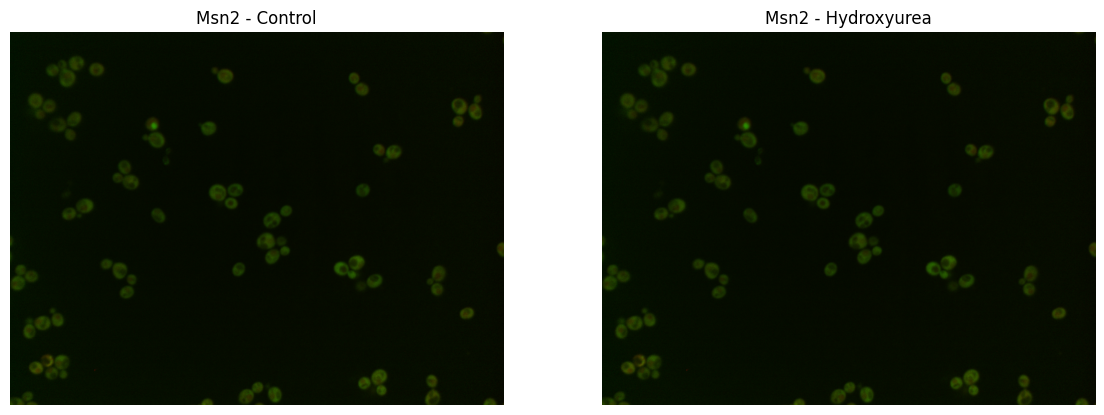

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

howt_g = np.array(Image.open('./data/WT_cyclops/MSN2_ch1_1.tif'))
howt_r = np.array(Image.open('./data/WT_cyclops/MSN2_ch2_1.tif'))
howt_img = np.stack((howt_r, howt_g, np.zeros_like(howt_r)), axis=-1)

hu_g = np.array(Image.open('./data/WT_cyclops/MSN2_ch1_1.tif'))
hu_r = np.array(Image.open('./data/WT_cyclops/MSN2_ch2_1.tif'))
hu_img = np.stack((hu_r, hu_g, np.zeros_like(hu_r)), axis=-1)

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(howt_img)
ax1.set_title("Msn2 - Control")
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(hu_img)
ax2.set_title("Msn2 - Hydroxyurea")
ax2.axis("off")
plt.show()

These images show the yeast transcription factor Msn2, expressed in control
cells compared to cells treated with hydroxyurea. The protein (tagged with GFP)
is shown in green, and since the CYCLoPS dataset uses a cytoplasmic RFP to
visualize the cell, the cytoplasm of the cell is shown in red. Most cells in
the control express Msn2 in the cytoplasm, but under hydroxyurea treatment,
Msn2 is now localized to the nucleus. These are the types of localization
changes that we would like to detect with our computational pipeline.

## Step 1: Segmenting images into single cell crops

The first step in our analysis will be segmenting these images into single cell crops. We'll use YeastSpotter to do this
since it's a general purpose segmentation method that will work on many kinds of modalities. We've integrated
YeastSpotter into this repository, and it can be called as below:


In [3]:
import warnings
warnings.filterwarnings("ignore")
import segmentation.yeastspotter.utils as ys_utils

ys_utils.segment_directory(input_dir = './data/WT_cyclops/',                        # Input directory
                           output_dir = './data/WT_cyclops_segmented/',             # Output directory to save segmentation
                           rescale = True,                                          # Rescale images to speed up segmentation
                           scale_factor = 2.0,                                      # Factor to rescale images (divide size by 2.0)
                           verbose = True,                                          # Print out process
                           contains_str = '_ch2_')                                  # Only segment images containing "ch2" (i.e. RFP channel)


Preprocessing images...
Preprocessing  MSN2_ch1_1.tif
Preprocessing  MSN2_ch2_1.tif

Running your images through the neural network...
Loading weights from  C:\Users\lualex\PycharmProjects\change_detection_book_chapter\segmentation\yeastspotter\mrcnn\../weights/deepretina_final.h5
Start detect 0    MSN2_ch1_1
Completed in 10.161163806915283
Start detect 1    MSN2_ch2_1
Completed in 8.114302635192871

Saving the masks...
Converting MSN2_ch1_1 to mask...
Completed in 0.21620464324951172
Converting MSN2_ch2_1 to mask...
Completed in 0.22377657890319824


Yeastspotter will produce segmentation masks where each cell is assigned its own unique integer:

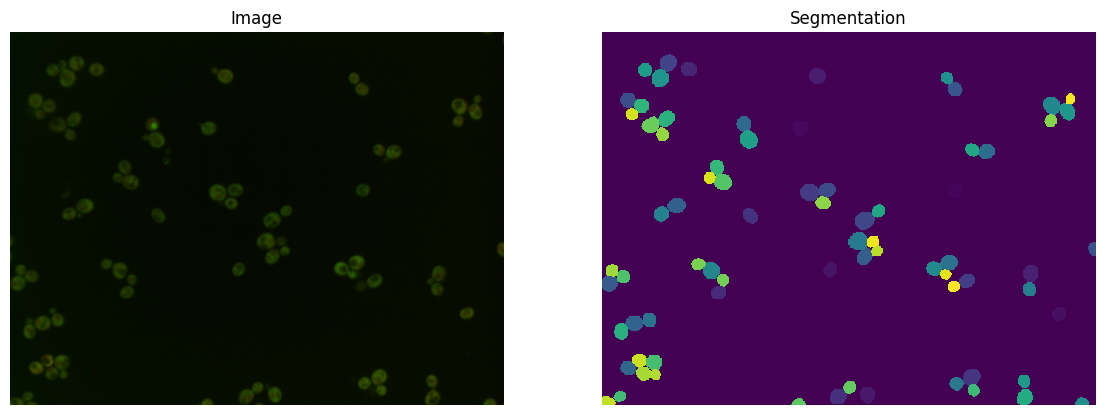

In [7]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

howt_g = np.array(Image.open('./data/WT_cyclops/MSN2_ch1_1.tif'))
howt_r = np.array(Image.open('./data/WT_cyclops/MSN2_ch2_1.tif'))
howt_img = np.stack((howt_r, howt_g, np.zeros_like(howt_r)), axis=-1)

howt_seg = np.array(Image.open('./data/WT_cyclops_segmented/masks/MSN2_ch2_1.tif'))

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(howt_img)
ax1.set_title("Image")
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(howt_seg, interpolation='nearest')
ax2.set_title("Segmentation")
ax2.axis("off")
plt.show()

We will use these segmentation masks to crop the full microscopy image into multiple 64x64 single cell crops. These
crops will be fed into a deep learning model that will learn and extract single cell feature representations. Since
the model we use is robust to the presence of e.g. multiple cells in a crop, we only need to use the center of each
segmented cell to determine crops (and not the exact boundaries of the segmentation).

In [1]:
import segmentation.yeastspotter.utils as ys_utils

ys_utils.batch_crop_single_cells(image_dir = './data/WT_cyclops/',                              # Image directory
                                 mask_dir = './data/WT_cyclops_segmented/masks/',               # Mask directory
                                 output_dir = './data/WT_cyclops_segmented/single_cells/',      # Output directory for single cells
                                 cropsize=64,                                                   # Pixel size of square to crop from images
                                 resize=64,                                                     # Pixel size of square to resize cropped images into
                                 additional_img_strs = [("_ch2_", "_ch1_")])                    # By default, the script will only segment images in the image
                                                                                                # directory with an identical name to the mask images
                                                                                                # To also segment additional images, provide a list of tuples
                                                                                                # of string replacements that will identify these images.

Working on MSN2_ch2_1.tif
Successfully cropped all images.


The above code block should result in a directory of single cell crops (with channels saved as individual images).
The code block below will show some random samples:

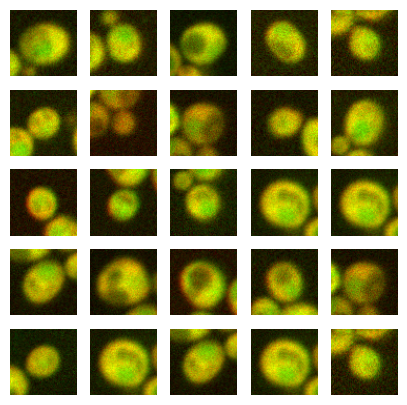

In [7]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
from skimage.exposure import rescale_intensity

single_cell_dir = './data/WT_cyclops_segmented/single_cells/'
single_cells = glob.glob(single_cell_dir + "*_ch2_*.tif")

fig = plt.figure(figsize=(5, 5))
fig_counter = 1
for cell_name in np.random.choice(single_cells, 25):
    gfp = np.array(Image.open(cell_name))
    rfp = np.array(Image.open(cell_name.replace("_ch2_", "_ch1_")))

    # Rescale intensity of raw tif files so they display nicely as RGB image
    gfp = rescale_intensity(gfp, out_range=(0, 1))
    rfp = rescale_intensity(rfp, out_range=(0, 1))
    img = np.stack((rfp, gfp, np.zeros_like(gfp)), axis=-1)

    ax = fig.add_subplot(5, 5, fig_counter)
    ax.imshow(img)
    ax.axis("off")

    fig_counter += 1

plt.show()

The above segmentation steps can be batched over a whole screen of images. This step is too time-consuming for our
tutorial, so if you would like to follow along with the next step, which involves training a self-supervised deep
learning model to learn feature representations of these images, you can download a complete screen of segmented
single cells from (ZENODO LINK). Otherwise, skip to Step 3, which involves extracting features from a trained neural
network (we provide weights in this step so you don't need to complete Step 2 for yourself.)

## Step 2: Train a self-supervised deep learning model on single cell crops